In [3]:
import pandas as pd
import numpy as np
from cataclop.ml.pipeline import factories

In [ ]:
d = factories.Dataset.factory('default')
d.load(force=True)

In [885]:
d

In [13]:
pd.concat([pd.DataFrame(d.players.describe()).T, d.players.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,17355.0,4.542380e+00,1.989305e+00,2.0,3.0,4.0,6.000,1.400000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,17355.0,1.251541e+01,3.037875e+00,4.0,10.0,13.0,15.000,2.000000e+01,int64
distance,17355.0,1.920982e+03,4.800349e+02,950.0,1600.0,2000.0,2200.000,3.200000e+03,int64
earnings,17355.0,6.586432e+06,2.246027e+07,0.0,515000.0,2123300.0,6220250.000,1.471275e+09,int64


In [14]:
import time

df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight'
               ]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='inner')

for f in agg_features:
    df['{}_r'.format(f)] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(1000)

odds = pd.DataFrame(columns=['odds_{:d}'.format(i) for i in range(20)], index=df.index)

races = df.groupby('race_id')

start = time.time()

for (id, race) in races:
    odds_sorted = sorted(race['final_odds_ref'].values)
    odds.loc[race.index, ['odds_{:d}'.format(i) for i, v in enumerate(odds_sorted)]] = odds_sorted
    
end = time.time()
print(end - start)

df = pd.concat([df,odds], axis=1)

df[['odds_{:d}'.format(i) for i in range(20)]] = df[['odds_{:d}'.format(i) for i in range(20)]].fillna(1000.0)

df['speed'] = (df['distance'] / df['time']).fillna(1000)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(0.)

df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.sort_index()
df_orig = df.copy()

336.8711278438568


In [15]:
df = df_orig[df_orig['category']=='ATTELE'].copy()

In [788]:
df_test = df_orig[df_orig['start_at'] > '2017-11-01'].copy()
df = df_orig[df_orig['start_at'] <= '2017-11-01'].copy()

df_test = df_test.sort_index()
df = df.sort_index()

In [429]:
def predict_proba_ordered(probs, classes_, all_classes):
    """
    probs: list of probabilities, output of predict_proba 
    classes_: clf.classes_
    all_classes: all possible classes (superset of classes_)
    """
    proba_ordered = np.zeros((probs.shape[0], all_classes.size),  dtype=np.float)
    sorter = np.argsort(all_classes) # http://stackoverflow.com/a/32191125/395857
    idx = sorter[np.searchsorted(all_classes, classes_, sorter=sorter)]
    proba_ordered[:, idx] = probs
    return proba_ordered


In [789]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df.index.droplevel(1).values

group_kfold = GroupKFold(n_splits=3)

features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(20)]

N_TARGETS = 6

df['pred_pos'] = N_TARGETS
for i in range(N_TARGETS):
    df['pred_{}'.format(i+1)] = 0.0

df['target'] = df['position'].copy()
df.loc[df['target'] > N_TARGETS, 'target'] = N_TARGETS-1
df['target'].fillna(N_TARGETS, inplace=True)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

models = [
    {
        'name': 'rf_10',
        'model': RandomForestClassifier(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'rf_30',
        'model': RandomForestClassifier(n_estimators=30),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestClassifier(n_estimators=100),
        'scaler': False
    },
    {
        'name': 'ada_10',
        'model': AdaBoostClassifier(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'ada_30',
        'model': AdaBoostClassifier(n_estimators=30),
        'scaler': False
    },
    {
        'name': 'ada_100',
        'model': AdaBoostClassifier(n_estimators=100),
        'scaler': False
    },
    {
        'name': 'knn_10',
        'model': KNeighborsClassifier(n_neighbors=10),
        'scaler': False
    },
    {
        'name': 'knn_30',
        'model': KNeighborsClassifier(n_neighbors=30),
        'scaler': False
    },
    {
        'name': 'knn_100',
        'model': KNeighborsClassifier(n_neighbors=100),
        'scaler': False
    }
]
'''
    {
        'name': 'rf_150',
        'model': RandomForestClassifier(n_estimators=150),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestClassifier(n_estimators=100),
        'scaler': False
    },
{
    'name': 'nn_100',
    'model': MLPClassifier(),
    'scaler': True
}
{
    'name': 'knn_5',
    'model': KNeighborsClassifier(n_neighbors=5),
    'scaler': False
},
{
    'name': 'ada',
    'model': AdaBoostClassifier(),
    'scaler': False
},

{
    'name': 'rf_50',
    'model': RandomForestClassifier(n_estimators=50),
    'scaler': False
},
{
    'name': 'svc',
    'model': SVC(probability=True),
    'scaler': True
}
'''
for model in models:
    for i in range(N_TARGETS):
        df['pred_{}_{}'.format(model['name'], i+1)] = 0.0
        df_test['pred_{}_{}'.format(model['name'], i+1)] = 0.0

    df['pred_{}'.format(model['name'])] = 0.0

for train_index, test_index in splits:
    
    for model in models:

        X_train = df[features].iloc[train_index].copy()
        y_train = df['target'].iloc[train_index]

        dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
        X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
        
        X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
        y_train = df['target'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]

        X_test = df[features].iloc[test_index].copy()
        y_test = df['target'].iloc[test_index]
    
        X_val = df_test[features].copy()

        X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
        X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

        X_train = X_train.values
        X_test = X_test.values
        X_val = X_val.values

        idx = df.iloc[test_index].index

        if model['scaler']:
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            X_val = scaler.transform(X_val)

        clf = model['model']
        clf.fit(X_train, y_train.values)

        p = clf.predict_proba(X_test)
    
        print( model['name'], log_loss(y_test.values, p) )

        for i in range(N_TARGETS):
            df.loc[idx, 'pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

        df.loc[idx, 'pred_{}'.format(model['name'])] = p[:, list(clf.classes_).index(1)]
    
        p = clf.predict_proba(X_val)
    
        for i in range(N_TARGETS):
            df_test['pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

    
    
    
    

rf_10 5.820373067932233
rf_30 2.1232115446385276
rf_100 1.5646596296630382
ada_10 1.7704386943036383
ada_30 1.7901384123044153
ada_100 1.7866647099872697
knn_10 6.427882342629517
knn_30 2.162264224863534
knn_100 1.5387200333260795
rf_10 6.31210258171041
rf_30 2.241757641353832
rf_100 1.5523702174724217
ada_10 1.7465281982484275
ada_30 1.7809303745408045
ada_100 1.7838253079918853
knn_10 6.226918678886174
knn_30 1.8691527176854477
knn_100 1.5767517527299908
rf_10 6.040354742573864
rf_30 2.161581292288158
rf_100 1.5376581889425969
ada_10 1.7427405547204806
ada_30 1.7746047600736228
ada_100 1.7839931101000344
knn_10 6.183756504135947
knn_30 2.0040258307101224
knn_100 1.5306433918077735


In [792]:
from gplearn.genetic import SymbolicTransformer

function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']

N_GP_FEATURES = 10

for i in range(N_GP_FEATURES):
    df['gp_feat_{}'.format(i+1)] = 0.
    df_test['gp_feat_{}'.format(i+1)] = 0.
    
df_test['target'] = df_test['position'].copy()
df_test.loc[df_test['target'] > N_TARGETS, 'target'] = N_TARGETS-1
df_test['target'].fillna(N_TARGETS, inplace=True)


X_train = df_test[features].copy()
y_train = df_test['target']

X_test = df[features].copy()
y_test = df['target']

X_train = X_train.values
X_test = X_test.values

gp = SymbolicTransformer(generations=10, population_size=2000,
                     hall_of_fame=100, n_components=N_GP_FEATURES,
                     function_set=function_set,
                     parsimony_coefficient=0.0005,
                     max_samples=0.9, verbose=1,
                     random_state=0, n_jobs=3)

gp.fit(X_train, y_train.values)

gp_features = gp.transform(X_test)

for i in range(N_GP_FEATURES):
    df['gp_feat_{}'.format(i+1)] = gp_features[:,i]


    

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.15 0.04392649163712136       12 0.20851187368108745 0.18001629904246141     20.77s
   1     6.19 0.10906963021865468        5 0.2318854459572267 0.18701455139655418     23.24s
   2     6.62 0.13961285700351572       12 0.2434260388940058 0.2435465295066672     21.83s
   3     5.59 0.15387834662360556       14 0.2603935804743463 0.19182476025845183     19.13s
   4     5.81 0.14589609226026393       14 0.2634871396675337 0.1639765244255887     16.15s
   5     7.03 0.16410477946238108        7 0.2659468396257277 0.15047278429222852     13.20s
   6     7.66 0.16895085491795384        6 0.26911421857388523 0.09816004471275273     10.09s
   7      7.4 0.16912801369024383       11 0.2646330949625973 0.14342131717500625      6.83s
   8     6.

In [794]:
df[['position'] + ['gp_feat_{}'.format(i+1) for i in range(N_GP_FEATURES)]]

position  gp_feat_1  gp_feat_2  gp_feat_3  gp_feat_4  gp_feat_5  \
race_id id                                                                      
1       1          4.0  -0.101015   0.038180   3.194383   3.194383   3.194383   
        2          1.0  -0.082479   0.031174   2.608203   2.608203   2.608203   
        3          5.0  -0.071429   0.026997   2.258770   2.258770   2.258770   
        4          3.0  -0.142857   0.053995   4.517540   4.517540   4.517540   
        5          2.0  -0.142857   0.053995   4.517540   4.517540   4.517540   
        6          6.0  -0.142857   0.053995   4.517540   4.517540   4.517540   
        7          7.0  -0.142857   0.053995   4.517540   4.517540   4.517540   
2       8          2.0  -0.117851   0.048113   3.726780   3.726780   3.726780   
        9          3.0  -0.166667   0.068041   5.270463   5.270463   5.270463   
        10         5.0  -0.096225   0.039284   3.042903   3.042903   3.042903   
        11         4.0  -0.166667   0.068041   5.270463   5.270463   5.270463   
        12         6.0  -0.166667   0.068041   5.270463   5.270463   5.270463   
        13         1.0  -0.166667   0.068041   5.270463   5.270463   5.270463   
3       14        16.0  -0.023623   0.005906   0.747018   0.747018   0.747018   
        15         7.0  -0.062500   0.015625   1.976424   1.976424   1.976424   
        16        15.0  -0.025516   0.006379   0.806872   0.806872   0.806872   
        17         8.0  -0.044194   0.011049   1.397542   1.397542   1.397542   
        18         5.0  -0.062500   0.015625   1.976424   1.976424   1.976424   
        19        11.0  -0.044194   0.011049   1.397542   1.397542   1.397542   
        20         1.0  -0.036084   0.009021   1.141089   1.141089   1.141089   
        21         9.0  -0.062500   0.015625   1.976424   1.976424   1.976424   
        22        12.0  -0.036084   0.009021   1.141089   1.141089   1.141089   
        23        14.0  -0.062500   0.015625   1.976424   1.976424   1.976424   
        24         6.0  -0.044194   0.011049   1.397542   1.397542   1.397542   
        25        10.0  -0.036084   0.009021   1.141089   1.141089   1.141089   
        26         3.0  -0.062500   0.015625   1.976424   1.976424   1.976424   
        27         2.0  -0.044194   0.011049   1.397542   1.397542   1.397542   
        28         4.0  -0.036084   0.009021   1.141089   1.141089   1.141089   
        29        13.0  -0.036084   0.009021   1.141089   1.141089   1.141089   
4       30        10.0  -0.055556   0.013095   0.470749   0.470749   0.470749   
...                ...        ...        ...        ...        ...        ...   
1234    8658       NaN  -0.025641   0.007112   0.810840   0.810840   0.810840   
1235    8659       5.0  -0.025641   0.007112   0.810840   0.810840   0.810840   
        8660       NaN  -0.031404   0.008710   0.993073   0.993073   0.993073   
        8661       2.0  -0.054393   0.015086   1.720052   1.720052   1.720052   
        8662       6.0  -0.034401   0.009541   1.087857   1.087857   1.087857   
        8663       NaN  -0.044412   0.012318   1.404417   1.404417   1.404417   
        8664       1.0  -0.038462   0.010667   1.216261   1.216261   1.216261   
        8665       NaN  -0.027196   0.007543   0.860026   0.860026   0.860026   
        8666       NaN  -0.031404   0.008710   0.993073   0.993073   0.993073   
        8667       4.0  -0.000000   0.000000   0.076923   0.277350   0.277350   
        8668       NaN  -0.038462   0.010667   1.216261   1.216261   1.216261   
        8669       NaN  -0.000000   0.000000   0.076923   0.277350   0.277350   
        8670       3.0  -0.031404   0.008710   0.993073   0.993073   0.993073   
        8671       7.0  -0.027196   0.007543   0.860026   0.860026   0.860026   
1239    8672       NaN  -0.022097   0.005524   0.698771   0.698771   0.698771   
        8673       7.0  -0.036084   0.009021   1.141089   1.141089   1.141089   
        8674       1.0  -0.000000   0.000000 

In [893]:

stacked_features = ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(3)]

for i in range(N_TARGETS):
    stacked_features = stacked_features + ['pred_{}_{}'.format(model['name'], i+1) for model in models]
    
stacked_features = stacked_features + ['gp_feat_{}'.format(i+1) for i in range(N_GP_FEATURES)]

stacked_features


['declared_player_count',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'pred_rf_10_1',
 'pred_rf_30_1',
 'pred_rf_100_1',
 'pred_ada_10_1',
 'pred_ada_30_1',
 'pred_ada_100_1',
 'pred_knn_10_1',
 'pred_knn_30_1',
 'pred_knn_100_1',
 'pred_rf_10_2',
 'pred_rf_30_2',
 'pred_rf_100_2',
 'pred_ada_10_2',
 'pred_ada_30_2',
 'pred_ada_100_2',
 'pred_knn_10_2',
 'pred_knn_30_2',
 'pred_knn_100_2',
 'pred_rf_10_3',
 'pred_rf_30_3',
 'pred_rf_100_3',
 'pred_ada_10_3',
 'pred_ada_30_3',
 'pred_ada_100_3',
 'pred_knn_10_3',
 'pred_knn_30_3',
 'pred_knn_100_3',
 'pred_rf_10_4',
 'pred_rf_30_4',
 'pred_rf_100_4',
 'pred_ada_10_4',
 'pred_ada_30_4',
 'pred_ada_100_4',
 'pred_knn_10_4',
 'pred_knn_30_4',
 'pred_knn_100_4',
 'pred_rf_10_5',
 'pred_rf_30_5',
 'pred_rf_100_5',
 'pred_ada_10_5',
 'pred_ada_30_5',
 'pred_ada_100_5',
 'pred_knn_10_5',
 'pred_knn_30_5',
 'pred_knn_100_5',
 'pred_rf_10_6',
 'pred_rf_30_6',
 'pred_rf_100_6',
 'pred_ada_10_6',
 'pred_ada_30_6',
 'pred_ada_100_6',
 'pred_knn_1

In [894]:
from sklearn.linear_model import LogisticRegression
from gplearn.genetic import SymbolicRegressor

N_TARGETS_STACKED = 20

df['target_stacked'] = df['position'].copy()
df.loc[df['target_stacked'] > N_TARGETS_STACKED, 'target_stacked'] = N_TARGETS_STACKED-1
df['target_stacked'].fillna(N_TARGETS_STACKED, inplace=True)

df['pred_stacked'] = 0.0
for i in range(N_TARGETS_STACKED):
    df['pred_stacked_{}'.format(i+1)] = 0.0
    df_test['pred_stacked_{}'.format(i+1)] = 0.0


In [895]:

for train_index, test_index in splits:

    X_train = df[stacked_features].iloc[train_index].copy()
    y_train = df['target_stacked'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], [])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
    y_train = df['target_stacked'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]


    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target_stacked'].iloc[test_index]
    
    X_val = df_test[stacked_features].copy()

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
    X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    X_val = X_val.values

    idx = df.iloc[test_index].index
    
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    #clf = MLPClassifier(hidden_layer_sizes=(60), alpha=0.01, activation='relu', batch_size=20)
    #clf = RandomForestClassifier(n_estimators=150)
    #clf = AdaBoostClassifier(n_estimators=250)
    #clf = SVC(probability=True)
    #clf = KNeighborsClassifier(n_neighbors=25)

    '''
    clf.fit(X_train, y_train.values)
    
    p = clf.predict_proba(X_test)
    
    print( log_loss(y_test.values, p) )

    df.loc[idx, 'pred_stacked'] = p[:, list(clf.classes_).index(1)]
    for i in range(N_TARGETS_STACKED):
        df.loc[idx, 'pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    p = clf.predict_proba(X_val)
    
    for i in range(N_TARGETS_STACKED):
        df_test['pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]
        
    '''
    
    reg = MLPRegressor(batch_size=20)
    reg.fit(X_train, y_train.values)
    
    p = reg.predict(X_test)
    df.loc[idx, 'pred_stacked'] = p
    
    print( mean_absolute_error(y_test.values, p) )



4.324735674650788
4.281398621723203
3.6597779317455643


In [896]:
df[['position', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(i+1) for i in range(N_TARGETS_STACKED)]+['pred_{}_1'.format(m['name']) for m in models]][:10]

position  final_odds_ref  pred_stacked  pred_stacked_1  \
race_id id                                                           
1       1        4.0             2.5      4.178388             0.0   
        2        1.0            29.4      3.945544             0.0   
        3        5.0            27.9      4.383537             0.0   
        4        3.0            14.1      0.202295             0.0   
        5        2.0             2.2      2.096705             0.0   
        6        6.0             6.4     -0.414076             0.0   
        7        7.0            21.4      2.103957             0.0   
2       8        2.0             4.2      3.430001             0.0   
        9        3.0             4.6     -2.592342             0.0   
        10       5.0            15.7     -1.462044             0.0   

            pred_stacked_2  pred_stacked_3  pred_stacked_4  pred_stacked_5  \
race_id id                                                                   
1       1              0.0             0.0             0.0             0.0   
        2              0.0             0.0             0.0             0.0   
        3              0.0             0.0             0.0             0.0   
        4              0.0             0.0             0.0             0.0   
        5              0.0             0.0             0.0             0.0   
        6              0.0             0.0             0.0             0.0   
        7              0.0             0.0             0.0             0.0   
2       8              0.0             0.0             0.0             0.0   
        9              0.0             0.0             0.0             0.0   
        10             0.0             0.0             0.0             0.0   

            pred_stacked_6  pred_stacked_7       ...        pred_stacked_20  \
race_id id                                       ...                          
1       1              0.0             0.0       ...                    0.0   
        2              0.0             0.0       ...                    0.0   
        3              0.0             0.0       ...                    0.0   
        4              0.0             0.0       ...                    0.0   
        5              0.0             0.0       ...                    0.0   
        6              0.0             0.0       ...                    0.0   
        7              0.0             0.0       ...                    0.0   
2       8              0.0             0.0       ...                    0.0   
        9              0.0             0.0       ...                    0.0   
        10             0.0             0.0       ...                    0.0   

            pred_rf_10_1  pred_rf_30_1  pred_rf_100_1  pred_ada_10_1  \
race_id id                                                             
1       1       0.000000      0.333333       0.260000       0.175375   
        2       0.192857      0.316667       0.286667       0.175015   
        3       0.200000      0.333333       0.240000       0.179613   
        4       0.042857      0.466667       0.270000       0.179613   
        5       0.142857      0.416667       0.260000       0.175015   
        6       0.000000      0.266667       0.220000       0.175375   
        7       0.142857      0.383333       0.280000       0.175015   
2       8       0.100000      0.100000       0.245000       0.166707   
        9       0.342857      0.166667       0.297500       0.166238   
        10      0.242857      0.200000       0.205000       0.166238   

            pred_ada_30_1  pred_ada_100_1  pred_knn_10_1  pred_knn_30_1  \
race_id id                                                                
1       1        0.169321        0.168359            0.0       0.033333   
        2        0.169180        0.167329            0.0       0.033333   
        3        0.170678        0.169254            0.1       0.133333   
        4        0.170678        0.169317    

In [830]:
fi = pd.Series(clf.feature_importances_, index=stacked_features+preprocessing.get_dummy_features(dummies))
print(fi.sort_values(ascending=False))

pred_ada_30_5            0.017348
pred_ada_100_3           0.017025
placed_3_count_r         0.016765
pred_ada_100_5           0.016571
pred_ada_30_6            0.015998
pred_rf_100_5            0.015891
pred_ada_100_1           0.015711
pred_ada_100_6           0.015638
pred_ada_100_2           0.015144
pred_rf_100_1            0.015138
pred_ada_30_1            0.015043
victory_earnings_r       0.014884
race_count_r             0.014844
pred_ada_30_3            0.014798
pred_rf_100_6            0.014708
placed_2_count_r         0.014499
pred_ada_30_4            0.014441
pred_ada_30_2            0.014223
pred_ada_100_4           0.014110
pred_knn_100_5           0.013667
pred_rf_100_3            0.013569
pred_rf_100_2            0.013473
pred_rf_30_5             0.013413
victory_count_r          0.013326
pred_knn_100_1           0.013142
pred_ada_10_6            0.012860
pred_ada_10_5            0.012832
prev_year_earnings_r     0.012709
pred_rf_100_4            0.012386
odds_4        

In [907]:
#df_test['strat_1'] = df_test['pred_stacked_1']
#races = df_test.groupby('race_id')

#df['strat_1'] = df['pred_stacked_1']+df['pred_stacked_2']-df['pred_stacked_3']-df['pred_stacked_4']-df['pred_stacked_5']-df['pred_stacked_6']
df['strat_1'] = df['pred_stacked'] * (df['final_odds_ref'].fillna(1))
#df['strat_2'] = df['pred_stacked_2']
races = df.groupby('race_id')


bets = []

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(['strat_1'], 1):
    
        r = race.sort_values(by=target, ascending=False)

        #r = r[(r['final_odds_ref']<20.) & (r['final_odds_ref'] > 2)]

        if len(r) == 0:
            continue

        player = r.iloc[0]
        
        if player['num'] in nums:
            continue
            
        odds = player['final_odds_ref']
        
        if odds > 20:
            continue
        
        '''
        
        if player['pred_1'] < 0.1:
            continue
        if player['pred_2'] < 0.075:
            continue
        if player['pred_3'] < 0.05:
            continue
            
        '''
        
        
        bet = 1#np.log(player['final_odds_ref'])#player['pred_1'] + player['pred_2']/2. + player['pred_3']/3.
        
        if odds < 3:
            bet = 1
        elif odds < 10:
            bet = 1
        else:
            bet = 1
            
        #bet = max(1., np.floor(1/odds*10))
            
        #bet = player['pred_stacked_1']*10

        profit = player['winner_dividend']/100.0 * bet - bet

        bets.append( (id, player['sub_category'], player['start_at'], bet, player['position'], player['final_odds'], player['pred_stacked_1'], player['pred_stacked_2'], player['pred_stacked_3'], player['num'], profit) )
        
        nums.append(player['num'])



bets = pd.DataFrame(bets, columns=['id', 'cat', 'date', 'bet', 'pos', 'odds', 'pred_1', 'pred_2', 'pred_3', 'num', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['bets'] = bets['bet'].cumsum()
bets['stash'] = bets['profit'].cumsum()


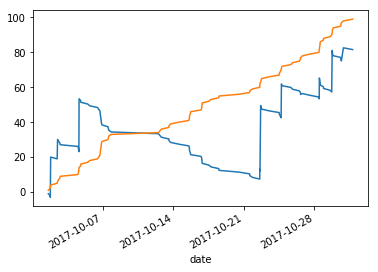

In [908]:
import matplotlib
%matplotlib inline
bets['stash'].plot()
bets['bets'].plot()

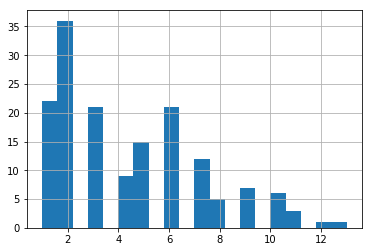

In [734]:
bets['pos'].hist(bins=20)

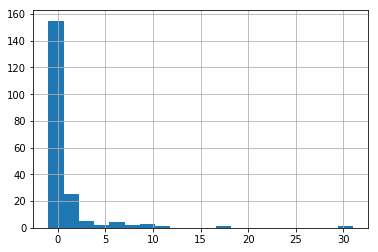

In [623]:
bets['profit'].hist(bins=20)

In [909]:
bets[0:100]

,id,cat,date,bet,pos,odds,pred_1,pred_2,pred_3,num,profit,bets,stash
date,,,,,,,,,,,,,
2017-10-01 14:48:00,2,GROUPE_I,2017-10-01 14:48:00,1,4.0,18.0,0.0,0.0,0.0,4,-1.0,1,-1.0
2017-10-01 18:55:00,24,COURSE_A_CONDITIONS,2017-10-01 18:55:00,1,9.0,13.3,0.0,0.0,0.0,6,-1.0,2,-2.0
2017-10-01 19:35:00,26,COURSE_A_CONDITIONS,2017-10-01 19:35:00,1,2.0,22.5,0.0,0.0,0.0,5,-1.0,3,-3.0
2017-10-01 20:26:00,28,COURSE_A_CONDITIONS,2017-10-01 20:26:00,1,1.0,31.8,0.0,0.0,0.0,3,23.0,4,20.0
2017-10-02 11:55:00,44,COURSE_A_CONDITIONS,2017-10-02 11:55:00,1,8.0,19.3,0.0,0.0,0.0,9,-1.0,5,19.0
2017-10-02 12:55:00,46,A_RECLAMER,2017-10-02 12:55:00,1,1.0,8.5,0.0,0.0,0.0,8,11.1,6,30.1
2017-10-02 15:08:00,50,HANDICAP_CATEGORIE_DIVISE,2017-10-02 15:08:00,1,5.0,19.4,0.0,0.0,0.0,9,-1.0,7,29.1
2017-10-02 18:13:00,56,INCONNU,2017-10-02 18:13:00,1,7.0,6.7,0.0,0.0,0.0,4,-1.0,8,28.1
2017-10-02 19:13:00,58,HANDICAP_DIVISE,2017-10-02 19:13:00,1,3.0,32.6,0.0,0.0,0.0,8,-1.0,9,27.1


cat     AMATEURS_AUTOSTART  AMATEURS_INTERNATIONALE_AUTOSTART  \
profit                -1.0                                0.8   
profit                 2.0                                1.0   

cat     APPRENTIS_LADS_JOCKEYS_AUTOSTART   AUTOSTART  A_RECLAMER_AUTOSTART  \
profit                              1.65   -0.300719                   2.1   
profit                              4.00  139.000000                   1.0   

cat     EUROPEENNE_AUTOSTART  GROUPE_I  GROUPE_II  INTERNATIONALE_AUTOSTART  \
profit             -0.588889      -1.0  -0.066667                 -0.382759   
profit              9.000000       1.0   3.000000                 29.000000   

cat     NATIONALE_AUTOSTART  
profit                  1.3  
profit                 10.0  


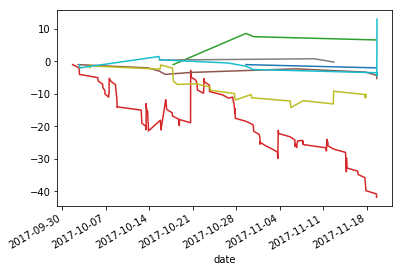

In [524]:
bets_cat = bets.groupby('cat')

print( pd.DataFrame([bets_cat['profit'].mean(), bets_cat['profit'].count()]) )

for cat, b in bets_cat:
    b['profit'].cumsum().plot(label=cat)
